# TIPS-Pentacene in Toluene
Notebook going through how to solvate a small organic molecule in a custom solvation box

Using the Toluene box from `Toluene_MDBox.ipynb` and https://ambermd.org/tutorials/basic/tutorial4b/index.php

Might also be handy to have the amber manual at the ready: https://ambermd.org/Manuals.php

In [ ]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

from ase.io import read, write
import nglview as nv
from MDAnalysis import Universe 

# needs ambertools if you don't already have it.
#!conda install -y -c conda-forge ambertools

First, we need to convert our xyz file to a pdb file, using openbabel. 

In this case, I found an sdf file of the molecule [here](https://pubchem.ncbi.nlm.nih.gov/compound/6_13-Bis_triisopropylsilylethynyl_pentacene), but the process is the same for xyzs. 

The sdf actually has MMFF94 partial charges, but I'm not sure how trustworthy those are. 

At this point we should consider whether we need to trust the FF model to produce an accurate geometry, or if we want to do DFT optimizations and later restrain the MD structure to the DFT structure. 

Since this is an organic molecule with no especially 'exotic' parts, we trust the FF for now. We can always go back and restrain the MM geometry to a DFT geometry we obtain at a later point.

In [4]:
!obabel -isdf ../../data/md/tips-pen/Conformer3D_CID_15530606.sdf -opdb ../../data/md/tips-pen/tips-pen.pdb > ../../data/md/tips-pen/tips-pen.pdb

*** Open Babel Warning  in ReadMolecule
There may be erroneous addition spaces or
the file may contains Atom Lists, which are ignored

2 molecules converted


Let's see how openbabel did

In [12]:
u = Universe('../../data/md/tips-pen/tips-pen.pdb')
print(u)
nv.show_mdanalysis(u)

<Universe with 100 atoms>


NGLWidget(max_frame=1)

I used MDAnalysis to view the pdb instead of the ASE reader because ASE isn't too good with pdb files. Furthermore MDAnalysis shows bonds based on the CONECT entries in the pdb, which isn't stored in the ASE atoms object. 

I also confirmed that there's the right amount of atoms in the molecule... 

The generated PDB contains residues "HETATM" and "ATOM" rows that are of the "UNL" and "UNK" residue, respectively. All the H's are UNK and the rest ar UNL. 

The ATOM record is used to identify proteins or nucleic acid atoms, and the HETATM record is used to identify atoms in small molecules. 

However, this is all atoms in a 'small molecule', and all from the same residue, which we name ourselves: TP1  
(then later TP2 for the dimer) 

This does all of that:

In [24]:
!sed -e 's/^ATOM  /HETATM/' \
    -e 's/\(^.\{17\}\)UNL/\1TP1/g' \
    -e 's/\(^.\{17\}\)UNK/\1TP1/g' \
    ../../data/md/tips-pen/tips-pen.pdb > ../../data/md/tips-pen/tips-pen_renamed.pdb

Antechamber time

In [28]:
!antechamber -i ../../data/md/tips-pen/tips-pen_renamed.pdb -fi pdb\
    -o ../../data/md/tips-pen/tips-pen_renamed.mol2 -fo mol2 -c bcc -s 2


Welcome to antechamber 17.3: molecular input file processor.

acdoctor mode is on: check and diagnosis problems in the input file.
-- Check Format for pdb File --
   Status: pass
         this may be a large multiple residue PDB file;
         large multiple residue PDB files are not supported.
         Continuing, but problems may be encountered.
-- Check Unusual Elements --
GAFF does not have sufficient parameters for molecules having unusual
         elements (those other than H,C,N,O,S,P and halogens).
         To ensure antechamber works properly, one may need to designate
         bond types for bonds involved with unusual elements.
         To do so, simply freeze the bond types by appending "F" or "f" 
         to the corresponding bond types in ac or mol2 files.
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
/home/jupyter-asod/.conda/envs

So that went very poorly.. Maybe the bonding wasn't correctly done by obenbabel. 

Furthermore, GAFF doesn't have parameters for Si. But the output provides info on how to just freeze them the bonds:

```
GAFF does not have sufficient parameters for molecules having unusual
         elements (those other than H,C,N,O,S,P and halogens).
         To ensure antechamber works properly, one may need to designate
         bond types for bonds involved with unusual elements.
         To do so, simply freeze the bond types by appending "F" or "f" 
         to the corresponding bond types in ac or mol2 files.
```

Before trying what they suggest, I noticed that the cif file carbon distances are stupidly small. As it also writes in the warnings. 

So.. once more from the top, but with a quick XTB optimization first.

In [30]:
from xtb.ase.calculator import XTB
from ase.optimize import FIRE, LBFGS

atoms = read('../../data/md/tips-pen/Conformer3D_CID_15530606.sdf')
atoms.calc = XTB()
opt = FIRE(atoms, trajectory='../../data/md/tips-pen/tips-pen_xtbopt.traj')
opt.run(fmax=0.05)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 10:23:19    -3403.388392*       3.7363
FIRE:    1 10:23:21    -3403.634663*       3.8250
FIRE:    2 10:23:23    -3403.758731*       2.0793
FIRE:    3 10:23:24    -3403.814392*       1.1307
FIRE:    4 10:23:26    -3403.819466*       0.9718
FIRE:    5 10:23:27    -3403.828015*       0.6799
FIRE:    6 10:23:28    -3403.837739*       0.3273
FIRE:    7 10:23:30    -3403.846943*       0.2936
FIRE:    8 10:23:31    -3403.855467*       0.4148
FIRE:    9 10:23:33    -3403.864413*       0.6207
FIRE:   10 10:23:34    -3403.874855*       0.6756
FIRE:   11 10:23:36    -3403.888151*       0.5611
FIRE:   12 10:23:37    -3403.903106*       0.2714
FIRE:   13 10:23:39    -3403.917435*       0.2665
FIRE:   14 10:23:41    -3403.931179*       0.5593
FIRE:   15 10:23:44    -3403.947574*       0.5519
FIRE:   16 10:23:45    -3403.966460*       0.1935
FIRE:   17 10:23:47    -3403.983111*       0.3893
FI

True

Check the opt visually:

In [31]:
from ase.io import Trajectory

traj = Trajectory('../../data/md/tips-pen/tips-pen_xtbopt.traj')
nv.show_asetraj(traj)

NGLWidget(max_frame=82)

At least nothing has flown off of the molecule.. Save as xyz and convert, since ASE's pdb writer is dodgy.

In [41]:
write('../../data/md/tips-pen/tips-pen_xtbopt.xyz', traj[-1], plain=True)

Convert to pdb. Not quiiite sure why we cannot just convert to mol2 immediately.. But.. 

In [40]:
!obabel -ixyz ../../data/md/tips-pen/tips-pen_xtbopt.xyz -opdb ../../data/md/tips-pen/tips-pen_xtb.pdb > ../../data/md/tips-pen/tips-pen_xtb.pdb

*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.
1 molecule converted


The above warning is strange as the xyz indeed _does_ contain the number of atoms... Anyways the conversion works, and the CONECT looks much better in this new pdb. One more renaming

In [42]:
!sed -e 's/\(^.\{17\}\)UNL/\1TP1/g' \
    ../../data/md/tips-pen/tips-pen_xtb.pdb > ../../data/md/tips-pen/tips-pen_xtb_renamed.pdb

Let's hope antechamber is more well behaved this time

In [43]:
!antechamber -i ../../data/md/tips-pen/tips-pen_xtb_renamed.pdb -fi pdb\
    -o ../../data/md/tips-pen/tips-pen_xtb_renamed.mol2 -fo mol2 -c bcc -s 2


Welcome to antechamber 17.3: molecular input file processor.

acdoctor mode is on: check and diagnosis problems in the input file.
-- Check Format for pdb File --
   Status: pass
-- Check Unusual Elements --
GAFF does not have sufficient parameters for molecules having unusual
         elements (those other than H,C,N,O,S,P and halogens).
         To ensure antechamber works properly, one may need to designate
         bond types for bonds involved with unusual elements.
         To do so, simply freeze the bond types by appending "F" or "f" 
         to the corresponding bond types in ac or mol2 files.
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Running: /home/jupyter-asod/.conda/envs/clean/bin/bondtype -j full -i ANTECHAMBER_BOND_TYPE.AC0 -o ANTECHAMBER_BOND

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 2, Name: C).
      Automatically increasing to 150000.
Info: Th

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 4, Name: C2).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 4, Name: C2).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 4, Name: C2).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 4, Name: C2).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 4, Name: C2).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 5, Name: C3).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 5, Name: C3).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 5, Name: C3).
      Automatically increasing to 20000.
Inf

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 7, Name: C5).
      Automatically increasing to 65000.
Info: Th

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 9, Name: C7).
      Automatically increasing to 105000.
Info: 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 11, Name: C9).
      Automatically increasing to 1

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 13, Name: C11).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 15, Name: C13).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 15, Name: C13).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 15, Name: C13).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 15, Name: C13).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 15, Name: C13).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 16, Name: C14).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 16, Name: C14).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 16, Name: C14).
      Automatically increasi

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 18, Name: C16).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 20, Name: C18).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 24, Name: C22).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 25, Name: C23).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 25, Name: C23).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 27, Name: C25).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasin

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 475000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 480000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 485000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 490000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 495000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 500000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increasing to 505000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 30, Name: C28).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 310000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 315000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 320000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 325000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 330000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 335000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increasing to 340000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 31, Name: C29).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 32, Name: C30).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 34, Name: C32).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 215000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 220000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 225000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 230000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 235000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 240000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increasing to 245000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 35, Name: C33).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 460000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 465000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 470000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 475000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 480000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 485000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 490000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 340000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 345000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 350000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 355000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 360000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 365000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 370000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 40, Name: C38).
      Automatically increasing to 225000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 41, Name: C39).
      Automatically increasing t

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 225000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 230000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 235000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 240000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 245000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 250000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increasing to 255000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 42, Name: C40).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 225000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 230000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 235000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 240000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 245000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 250000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increasing to 255000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 43, Name: C41).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 45, Name: C43).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 47, Name: H1).
      Automatically increasing to 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 49, Name: H3).
      Automatically increasing to 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 51, Name: H5).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 51, Name: H5).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 51, Name: H5).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 51, Name: H5).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 51, Name: H5).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 52, Name: H6).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 52, Name: H6).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 52, Name: H6).
      Automatically increasing to 20

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 53, Name: H7).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 53, Name: H7).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 54, Name: H8).
      Automatically increasing to 35000

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 56, Name: H10).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 58, Name: H12).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 60, Name: H14).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 62, Name: H16).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 64, Name: H18).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 66, Name: H20).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 68, Name: H22).
      Automatically increasing 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 70, Name: H24).
      Automatically increasi

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 72, Name: H26).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 110000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 115000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 120000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 74, Name: H28).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 125000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 130000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 76, Name: H30).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 135000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 140000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 145000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 78, Name: H32).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 150000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 155000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 80, Name: H34).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 81, Name: H35).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 81, Name: H35).
      Automatically increas

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 82, Name: H36).
      Automatically increasing to 160000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 82, Name: H36).
      Automatically increasing to 165000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 82, Name: H36).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 82, Name: H36).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 83, Name: H37).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 83, Name: H37).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 83, Name: H37).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 83, Name: H37).
      Automatically increasin

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 84, Name: H38).
      Automatically increasing to 170000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 84, Name: H38).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 85, Name: H39).
      Automatically increasing 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 87, Name: H41).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 220000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 225000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 230000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 235000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 240000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 245000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increasing to 250000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 88, Name: H42).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 415000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 420000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 425000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 430000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 435000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 440000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increasing to 445000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 89, Name: H43).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 90, Name: H44).
      Automatically increasing to 230000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 90, Name: H44).
      Automatically increasing to 235000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 91, Name: H45).
      Automatically increasing 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 175000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 180000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 185000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 190000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 195000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 200000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increasing to 205000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 92, Name: H46).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 30000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 35000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 40000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 45000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 425000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 430000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 435000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 440000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 445000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 450000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increasing to 455000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 93, Name: H47).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 85000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 90000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 95000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 100000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing to 105000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 95, Name: H49).
      Automatically increasing 

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 270000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 275000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 280000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 285000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 290000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 295000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increasing to 300000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 96, Name: H50).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 250000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 255000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 260000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 265000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 270000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 275000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increasing to 280000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 97, Name: H51).
      Automatically increa

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 50000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 55000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 60000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 65000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 70000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 75000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to 80000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 99, Name: H53).
      Automatically increasing to

This can take quite a while since it's doing a (low-quality, AM1 ) QM calculation to get charges. You can follow the progress in the `sqm.out` out file. We can always get more accurate charges later, if needed. 

Based on the rings-info and the MAXPATHATOMNUM outputs, I think we're running into [this problem](http://archive.ambermd.org/201704/0139.html)

> Yeah, we see this with multi-cyclic residues like CB6/CB7. Antechamber has
a maximum path length setting (see the -pl command) to help with this. Try
setting it to something like "**-pl 15**". My understanding is that this will
prevent antechamber from continuing to search for equivalent atoms beyond
15 bond lengths, which should be fine. As Dave indicated, without this
setting it will continue the search by circling around the molecule,
probably infinitely.

So antechamber messes up when there's a bunch of connected rings.. A required pathlength of 185000 atoms is slightly insane. Great. But it's a simple fix.

So I'm killing the process above and doing it again with that `pl` command

In [44]:
!antechamber -i ../../data/md/tips-pen/tips-pen_xtb_renamed.pdb -fi pdb\
    -o ../../data/md/tips-pen/tips-pen_xtb_renamed.mol2 -fo mol2 -c bcc -s 2 -pl 15


Welcome to antechamber 17.3: molecular input file processor.

acdoctor mode is on: check and diagnosis problems in the input file.
-- Check Format for pdb File --
   Status: pass
-- Check Unusual Elements --
GAFF does not have sufficient parameters for molecules having unusual
         elements (those other than H,C,N,O,S,P and halogens).
         To ensure antechamber works properly, one may need to designate
         bond types for bonds involved with unusual elements.
         To do so, simply freeze the bond types by appending "F" or "f" 
         to the corresponding bond types in ac or mol2 files.
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Running: /home/jupyter-asod/.conda/envs/clean/bin/bondtype -j full -i ANTECHAMBER_BOND_TYPE.AC0 -o ANTECHAMBER_BOND

Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 38, Name: C36).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 15000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 20000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 39, Name: C37).
      Automatically increasing to 25000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 40, Name: C38).
      Automatically increasing to 10000.
Info: The number of path atoms exceeded MAXPATHATOMNUM for atom (ID: 40, Name: C38).
      Automatically increasing to

Info: The number of rings (1736) exceeded the default (1000).



Ok, it still gives all the same reports, but actually finishes and creates a mol2. Yay.

It created a bunch of other files in the rundir (of this notebook), which I've manually moved to the data dir.


Lets continue, but this happens if we don't add the F:

In [45]:
!parmchk2 -i ../../data/md/tips-pen/tips-pen_xtb_renamed.mol2 -f mol2 -o ../../data/md/tips-pen/tips-pen_xtb_renamed.frcmod

         for improper_flag [0], group_id [0], and equivalent_flag [0].
         It is recommended to add the new atom type (Si) to PARMCHK.DAT.
Segmentation fault (core dumped)


Ok... So lets add it. The Si atoms have indices 1 and 2 (just check the file). So all bonds containing 1 or 2 should have an F. 

The 4 columns in the BOND section are: BOND ID, ATOM1 ID, ATOM2 ID, BOND TYPE.   

In [66]:
with open('../../data/md/tips-pen/tips-pen_xtb_renamed.mol2', 'r') as f:
    lines = f.readlines()
    
new_lines = []
in_bond = False
for line in lines:
    if '@<TRIPOS>SUBSTRUCTURE' in line:
        in_bond = False
    if in_bond:
        bond_id, at1, at2, btyp = line.split()
        if (at1 in ['1', '2']) or (at2 in ['1', '2']):
            line = line.replace('   \n', 'F  \n')
    new_lines.append(line)    
    if '@<TRIPOS>BOND' in line:
        in_bond = True

with open('../../data/md/tips-pen/tips-pen_xtb_renamed_fixed.mol2', 'w') as f:
    for line in new_lines:
        f.write(line)

In [69]:
!parmchk2 -i ../../data/md/tips-pen/tips-pen_xtb_renamed_fixed.mol2 -f mol2 -o ../../data/md/tips-pen/tips-pen_xtb_renamed_fixed.frcmod

The line above did NOT work at first, but recommended me to add the new atom type in 'PARMCHK.dat'. So I added the following line to it at this position:

```
# adding new atom type from here
# For example:
# PARM n5       0               0      14.01    0       7
PARM    Si      0               0       28.09   0       14
```
And then it worked. 

The PARMCHK.dat file location depends on where you installed ambertools. If you did so with conda, it will be in your conda folder, i.e.:

`.conda/envs/clean/dat/antechamber`

To get an idea about where it is:

In [70]:
!which parmchk2

/home/jupyter-asod/.conda/envs/clean/bin/parmchk2


Notice now that the resulting frcmod has added a lot of zero parameters:

In [71]:
!cat ../../data/md/tips-pen/tips-pen_xtb_renamed_fixed.frcmod

Remark line goes here
MASS
Si 28.090        0.000               ATTN, no polarizability parameter

BOND
Si-c3    0.00   0.000       ATTN, need revision

ANGLE
Si-c3-c3    0.000       0.000   ATTN, need revision
Si-c3-hc    0.000       0.000   ATTN, need revision
c3-Si-c3    0.000       0.000   ATTN, need revision

DIHE
c3-Si-c3-c3   1    0.000         0.000           0.000      ATTN, need revision
c3-Si-c3-hc   1    0.000         0.000           0.000      ATTN, need revision

IMPROPER

NONBON
  Si          0.0000  0.0000             ATTN, need revision





So in the resulting MD run, we should _really_ put on some restraints between Si and its connected atoms.. 

You could also consider adding some LJ parameters here if you're so inclined.. 

There are no other parameters in the frcmod, I _really_ hope that means that all the other parameters are standard.

Using `tleap` for generating the prmtop, of course it turned out that there were a ton of duplicate bonds in the mol2. Which it is too stupid to ignore. I think that obenbabel generates 2 bonds when it thinks it's a double bond between carbon atoms? 

In any case, I at this point gave up to fix it in a smart way, and simply manually (gregrharhgj) edited the bond table in `tips-pen_xtb_renamed_fixed_rebonded.mol2` (a copy of the previous mol2), to delete the duplicate bonds. This requires changing the numbers of bonds at the top of the file, and also re-indexing the `BOND ID` row... If you're using vim, ctrl-x is your friend here.. 

I also didn't use an input script for tleap but did it in a terminal to follow along more closely what problems it had. 

So i went to the ../data/md/tips-pen/ dir and
```bash
tleap -f oldff/leaprc.ff99SB
```

and did the following in tleap:
```
source leaprc.gaff

TP1 = loadmol2 tips-pen_xtb_renamed_fixed_rebonded.mol2

loadamberparams tips-pen_xtb_renamed_fixed.frcmod

check TP1

saveoff TP1 tips-pen.lib

saveamberparm TP1 tips-pen.prmtop tips-pen.inpcrd
```

Well wasn't that FUN ... 

(if you run into more problems with the Si or want actual parameters, you could maybe just make them pretend-carbons, see http://archive.ambermd.org/201507/0422.html)

### Solvating in Toluene: Failed attempt with my old Toluene box (that was OPLS-parametrized)

I got the last_frame.pdb from `cpptraj` in the hopes that it generates pdbs that amber is happy with. 

```
cpptraj 

parm toluenebox.prmtop
trajin toluenebox_npt.dcd
trajout plz2.pdb onlyframes 200
go
```

and then moved plz2.pdb to the right folder... 

In [77]:
u = Universe('../../data/md/toluene/last_frame.pdb')

In [78]:
nv.show_mdanalysis(u)

NGLWidget()

Erhm so this box was made with OPLS, not GAFF.. Because I think I found a paper showing that OPLS does these kinds of solvents quite well.. But we cannot just combine OPLS with GAFF like barbarians.. 

### GAFF Toluene for GAFF TIPS-Pen!
Instead: https://virtualchemistry.org/ff.php has verified GAFF parameters for toluene. -BUT in gromacs format.


So we should

1. Convert our GAFF stuff to gromacs using parmed to get a tips-pen.top
2. Use `gmx solvate` to make the final system. 

That requires installation of gromacs. Which is [relatively straightforward](https://manual.gromacs.org/5.1.4/install-guide/index.html).

Then I used `parmed` to convert the .prmtop and .inpcrd to the gromacs .top/.gro format. 

(`!conda install -c conda-forge parmed`)

In [4]:
import parmed as pmd
amber = pmd.load_file('../../data/md/tips-pen/tips-pen.prmtop', '../../data/md/tips-pen/tips-pen.inpcrd')
amber.save('../../data/md/tips-pen/tips-pen.top')
amber.save('../../data/md/tips-pen/tips-pen.gro')

These files do not work directly out of the box, however. 

Some manual editing necessary.

#### Create a system.top that includes itp versions of the tops from step 1
1. The `system.top` needs to contain all `[ atomtypes ]` in the system. So - if you are SURE that you have the same type of forcefield in your various .tops - concatenate the atomtypes from your tops into the `system.top` 
2. Copy your solute and solvent .top files to .itp, and remove the following blocks: 
```
[ defaults ]
[ system ]
[ molecules ]
```
3. Include the new .itp files in the top of `system.top`, e.g.: 
```
#include "tips-pen.itp"      ; Include the solute topology
#include "toluene.itp"       ; Include the solvent topology
```
4. Add the resnames of your solute and solvent to `[ molecules ]` at the bottom of your `system.top`, e.g.:
```
[ molecules ]
; Compound        #mols
TP1                1
MOL              2254
```
5. Set the box of the _solvent_ to a very small buffer e.g. 0.1 with gmx editconf: 
```
gmx editconf -f toluene.gro -o toluene.gro -c -d 0.1
``` 
6. Set the box of the _solute_ to the final box size you want, e.g. (here for 75 Å square box):
```
gmx editconf -f tips-pen.gro -o tips-pen.gro -c -box 7.5 7.5 7.5
```
7. Solvate your system:
```
gmx solvate -cp tips-pen.gro -cs toluene.gro -o tips-pen_tol.gro -p system.top`
```
Then you have the `tips-pen_tol.gro` and `system.top` files you can run in (gromacs) or OpenMM

###### Some more details on various .top formats: 
What is in the virtualchemistry atomtypes:

`;name   bond_type     mass     charge   ptype   sigma         epsilon       Amb`

What parmed creates:

`; name    at.num    mass    charge ptype  sigma      epsilon`

So be VERY careful you put the right numbers the right places, and that you even _can_.

Here, the _only_ different atom in TIPS was Si.. And we don't have any LJs for that anyways, so.. It was easy!

##### Setting up the MD simulation

We need to find atom indices and create/modify bonds between Si and carbons, since GAFF didn't knew what to do with those. 

In [121]:
import sys
sys.path.append('../../')
from cmm.md.cmmsystems import CMMSystem
from cmm.tools.ase_openmm import sys_as_ase 
import os

system = CMMSystem(tag='equil', fpath=os.getcwd())
system.system_from_gromacs('../../data/md/tips-pen/final_solvated/system.top', 
                        '../../data/md/tips-pen/final_solvated/tips-pen_tol.gro')

Let's check how it looks

In [120]:
atoms = system.to_ase()
nv.show_ase(atoms)

NGLWidget()

In [79]:
# writing out the final tips-pen from the MD box to look at indices in the ase gui
from ase.io import write
write('tips-pen-from-openmm.xyz', atoms[:100], plain=True)

Let's use a 'normal' C-C bond as our Si-C bond. There is such a bond between atoms 21 and 23

In [96]:
dist, k, _ = system.get_bond(21, 23)
dist

Quantity(value=0.15375, unit=nanometer)

Check a bond between Si and a nearby C:

In [122]:
system.get_bond(0, 2)

Bond between Si-C didn't exist, please use add_bond


(Quantity(value=0.0, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/(nanometer**2*mole)),
 'C5C6')

Apparently it spits out zero and then thinks there is no bond. But it seems to work adding bonds using `update_bond`. 

The first MD equilibration attempt only adds bonds, and trusts the parametrization enough to let it be unrestrained. 

I made a runscript and ran it on the DTU HPC:

```python
import os
import numpy as np
from cmm.md.cmmsystems import CMMSystem

sys = CMMSystem(tag='equil', fpath=os.getcwd())

sys.system_from_gromacs('system.top', 'tips-pen_tol.gro')
sys.add_barostat()
sys.set_integrator()

### restrain all Si-C bonds
# Let's use a C-C k and the current dist it has.
dist, k, _ = sys.get_bond(21, 23) # a C-C bond
si_idx = [0, 1]
c_idxs = [[2, 3, 4, 20], [5, 6, 7, 21]]
for i, si in enumerate(si_idx):
    for c in c_idxs[i]:
        # the bonds are already in place, just with
        # 0 k and dist. Thus we use update_bond
        # not set_bond
        d = np.linalg.norm(sys.positions[si]
                           - sys.positions[c])
        sys.update_bond(si, c, d, k)
### Let's also use C vdw parameters for Si
# Get all NB params
charges, sigmas, epsilons = sys.get_nonbonded(list(range(100))

sig = sigmas[2]  # idx of one of the carbons
eps = epsilons[2]
sys.adjust_lj([0, 1], {'Si': (eps, sig)})

sys.init_simulation()
sys.minimize(maxIterations=10000)
sys.standard_reporters()
sys.run(time_in_ns=10)
```

Seems like GAFF is _not_ very good at keeping aromatic rings rigid, and it often moves the TIPs groups weirdly "back" around its pentacene:

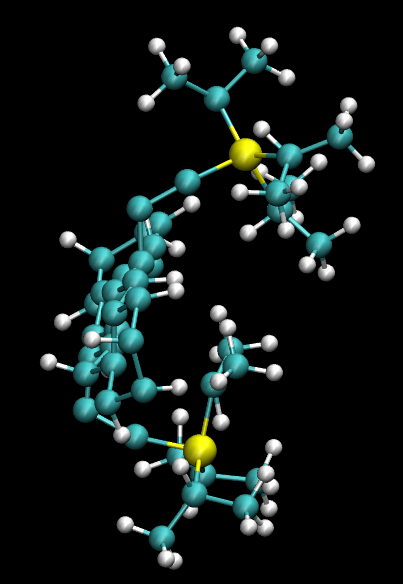


Thus, we unwillingly return to the 0th order approximation and simply restrain all TIPS-Pen atoms instead, trusting the XTB geometry - for now. 

This is NOT so good in this case, as we already KNOW that TIPS-Pen should exist in quite a few different conformers. 

What would of course need to be done as a 1st order approximation is to solvate a couple of the most expressed conformers instead. -Failing a proper parametrization. But even a proper parametrization would maybe still require very long MD sampling times to properly sample all conformers. So maybe the first idea is even better. Look into how the first TIPS-Pen paper did their MD to sample conformers..

The second equilibration, using restraints on all atom positions of TIPS-Pen:

```python
import os
import numpy as np
from cmm.md.cmmsystems import CMMSystem

sys = CMMSystem(tag='equil_01_restrained', fpath=os.getcwd())

sys.system_from_gromacs('system.top', 'tips-pen_tol.gro')
sys.add_barostat()
sys.set_integrator()

### Restrain all atoms to XTB position
indices = list(range(100))
sys.restrain_atoms(indices)

### Let's also use C vdw parameters for Si
# Get all NB params
charges, sigmas, epsilons = sys.get_nonbonded(indices)

sig = sigmas[2]  # idx of one of the carbons
eps = epsilons[2]
sys.adjust_lj([0, 1], {'Si': (eps, sig)})

sys.init_simulation()
sys.minimize(maxIterations=10000)
sys.standard_reporters()
sys.run(time_in_ns=10)

```

# The Excimer

We don't have a DFT S1S0 (S1) excimer structure yet, but let us make do for now with the structure from the restrained optimization from here: https://gitlab.com/asod/tipspen_excimer_xss (requires invitation apparently, sorry)

In [216]:
from ase.io import Trajectory
traj = Trajectory('longitudinal_opt_09.traj')
monotraj = [atoms[100:] for atoms in traj]
v = nv.show_asetraj(monotraj)
#v.children[0].add_representation('licorice')
v.add_label(labelType="atomindex", color='red')
v

NGLWidget(max_frame=343)

Hydrogrens 63 and 148 seems to have switched monomer... 

In [217]:
from ase import Atoms
atoms = traj[-1]
a = Atoms()
for i in range(63):
    a.append(atoms[i])
a.append(atoms[148])
for i in range(64, 100):
    a.append(atoms[i])
b = Atoms()
for i in range(100, 148):
    b.append(atoms[i])
b.append(atoms[63])
for i in range(149, 200):
    b.append(atoms[i])
    
nv.show_ase((a+b)[100:])

NGLWidget()

That fixed it.. Now we need to check if the GRO order is the same as the atoms order

In [218]:
atoms = a + b

It looks like it.. But I'd better check for each atom individually, so we don't have bonding errors.

So let's align each monomer to the org gro positions, and check distances between the closest of the same element. 

In [52]:
import rmsd
from ase import Atoms

def gro_to_ase(gro):
    ''' Make ASE atoms object out of gro file '''
    with open(gro, 'r') as f:
        gro = f.readlines()
    num_atms = int(gro[1])
    
    pos = np.zeros((num_atms, 3))
    els = []
    for i, line in enumerate(gro[2:-1]):
        parts = line.split()
        el = ''.join(p for p in parts[1] if not p.isnumeric())
        els.append(el)
        pos[i] = np.array([float(x)  * 10 for x in parts[-3:]])
    
    cell = np.array([float(x) for x in gro[-1].split()])
    atoms = Atoms(''.join(el.capitalize() for el in els), positions=pos, cell=cell)
    return atoms

def align(idx, atoms, ref):
    ''' Align the [idx] atoms to the positions of ref[idx]
        assuming the idx is the same for atoms and ref.

        Iterate over it ~15 times to get best results. 
    '''

    ref_pos = ref[idx].get_positions()
    atm_pos = atoms[idx].get_positions()

    # Translate atoms to ref
    ref_c = rmsd.centroid(ref_pos)
    atm_c = rmsd.centroid(atm_pos)
    atm_pos += (ref_c - atm_c)

    # Get rotation matrix via the Kabsch algo
    U = rmsd.kabsch(ref_pos, atm_pos)

    pos = atoms.get_positions() + (ref_c - atm_c)
    new_pos = np.dot(pos, U.T)

    return new_pos

Only one C-C distance gro-xtb is over 1 Å after alignment. It is _most likely_ the same order. Now for mono2

In [236]:
mono = atoms[100:].copy()
for i in range(30):
    pos = align(list(range(100)), mono, gro)
    mono.set_positions(pos)

for i, (g, a) in enumerate(zip(gro, mono)):
    dist = np.linalg.norm(g.position - a.position)
    if dist > 1:
        print(f'{i:03d}: {g.symbol:2s}-{a.symbol:2s}: {dist:4.2f} Å ****** ')
    else:
        print(f'{i:03d}: {g.symbol:2s}-{a.symbol:2s}: {dist:4.2f} Å')

000: Si-Si: 0.36 Å
001: Si-Si: 0.24 Å
002: C -C : 0.33 Å
003: C -C : 0.38 Å
004: C -C : 0.43 Å
005: C -C : 0.32 Å
006: C -C : 0.36 Å
007: C -C : 0.32 Å
008: C -C : 0.26 Å
009: C -C : 0.37 Å
010: C -C : 0.28 Å
011: C -C : 0.41 Å
012: C -C : 0.37 Å
013: C -C : 0.44 Å
014: C -C : 0.39 Å
015: C -C : 0.24 Å
016: C -C : 0.34 Å
017: C -C : 0.54 Å
018: C -C : 0.60 Å
019: C -C : 0.40 Å
020: C -C : 0.08 Å
021: C -C : 0.18 Å
022: C -C : 0.33 Å
023: C -C : 0.41 Å
024: C -C : 0.51 Å
025: C -C : 0.54 Å
026: C -C : 0.52 Å
027: C -C : 0.53 Å
028: C -C : 0.52 Å
029: C -C : 0.52 Å
030: C -C : 0.52 Å
031: C -C : 0.54 Å
032: C -C : 0.50 Å
033: C -C : 0.53 Å
034: C -C : 0.53 Å
035: C -C : 0.55 Å
036: C -C : 0.49 Å
037: C -C : 0.50 Å
038: C -C : 0.52 Å
039: C -C : 0.54 Å
040: C -C : 0.50 Å
041: C -C : 0.53 Å
042: C -C : 0.55 Å
043: C -C : 0.57 Å
044: C -C : 0.48 Å
045: C -C : 0.50 Å
046: H -H : 0.36 Å
047: H -H : 0.43 Å
048: H -H : 0.55 Å
049: H -H : 0.40 Å
050: H -H : 0.32 Å
051: H -H : 0.31 Å
052: H -H : 

Even smaller distances there. 

Thus, we can continue with hacking together our own gro file with the positions from the XTB opt. 

In [135]:
with open('../../data/md/tips-pen/final_solvated/tips-pen.gro', 'r') as f:
    org_gro = f.readlines()
    

org_gro

['GROningen MAchine for Chemical Simulation\n',
 '  100\n',
 '    1TP1     Si    1   0.592   0.004  -0.002\n',
 '    1TP1    Si1    2  -0.592   0.001   0.003\n',
 '    1TP1      C    3   0.651  -0.065  -0.172\n',
 '    1TP1     C1    4   0.655   0.184   0.017\n',
 '    1TP1     C2    5   0.654  -0.099   0.149\n',
 '    1TP1     C3    6  -0.656   0.159   0.092\n',
 '    1TP1     C4    7  -0.653   0.006  -0.180\n',
 '    1TP1     C5    8  -0.652  -0.154   0.100\n',
 '    1TP1     C6    9   0.600  -0.206  -0.200\n',
 '    1TP1     C7   10   0.804  -0.061  -0.186\n',
 '    1TP1     C8   11   0.612   0.247   0.150\n',
 '    1TP1     C9   12   0.611   0.273  -0.099\n',
 '    1TP1    C10   13   0.806  -0.098   0.162\n',
 '    1TP1    C11   14   0.603  -0.243   0.148\n',
 '    1TP1    C12   15  -0.613   0.287   0.021\n',
 '    1TP1    C13   16  -0.612   0.164   0.238\n',
 '    1TP1    C14   17  -0.805   0.014  -0.191\n',
 '    1TP1    C15   18  -0.602  -0.112  -0.263\n',
 '    1TP1    C16   19

This code generates a gro in the right format. 

In [278]:
header = 'TIPS-PP XTB Geometry (WIP)\n'
num_atms = len(atoms)
with open('../../data/md/tips-pen/excimer/TIPS-PP.gro', 'w') as f:
    f.write(header)
    f.write(f'  {num_atms:d}\n')

    # Generate the right format
    mol = 1
    el_pre = atoms[0].symbol
    ct = 0
    for i, atom in enumerate(atoms):
        if (i % 100 == 0) and (i != 0):
            mol += 1  # change mol # at 100
        if i > 1:
            el_pre = atoms[i - 1].symbol

        # Get the annoying element number format, i.e. C, C1, C2, ... (why not just C0... arhg)
        el = atom.symbol
        if el != el_pre:
            ct = 0
        if ct == 0:
            atm = f'{el}'
        else:
            atm = f'{el}{ct}'

        m = f'{mol}TP1'
        x, y, z = atom.position * 0.1
        line = f'    {m:8}{atm:5}{i + 1:3}{x:8.3f}{y:8.3f}{z:8.3f}\n'
        f.write(line)
        ct +=1


Now go to the directory and center the dimer in a 75 Å box:

```bash
gmx editconf -f TIPS-PP.gro -o TIPS-PP.gro -c -box 7.5 7.5 7.5
```

Copy the files you need:
```bash
cp ../final_solvated/tips-pen.itp tips-pen1.itp
cp ../final_solvated/tips-pen.itp tips-pen2.itp
cp ../final_solvated/toluene.gro .
cp ../final_solvated/toluene.itp
cp ../final_solvated/system.top .
``` 

And edit the system.top (see the file for details)

Then solvate
```bash
gmx solvate -cp TIPS-PP.gro -cs toluene.gro -o tips-pp_tol.gro -p system.top
```

It added 2249 toluenes this time.. Seems decent. 

Consider, however, for later, if you prefer the pain of the SAME box size or the SAME amount of toluenes.. You can't have both.. :D 

In [282]:
nv.show_ase(gro_to_ase('../../data/md/tips-pen/excimer/tips-pp_tol.gro'))

NGLWidget()

And there we have it!

# TIPS-Pentacene in Custom Solvents: Chloroform 

virtualchemistry.org has a .gro and a .top for Chloroform (trichloromethane)

The data from the website is in `../../data/md/chloroform/`

- Copied the files over to `../../data/md/tips-pen_chloroform/`  
- Converted the .top to .itp  
- Did `gmx editconf -f chloroform.gro -o chloroform.gro -c -d 0.1`
- `gmx editconf -f tips-pen.gro -o tips-pen.gro -c -box 7.5 7.5 7.5`
- `gmx solvate -cp tips-pen.gro -cs chloroform.gro -o tips-pen_chloroform.gro -p system.top`


In [53]:
nv.show_ase(gro_to_ase('../../data/md/tips-pen_chloroform/tips-pen_chloroform.gro'))

NGLWidget()

Transfered all the files to HPC: `~/PENTACENE/2023/2023_TIPS-Pen_MD/chloroform/equil_01_restrained` and running restrained equilibration/production like with toluene

### Excimer

Like with toluene, but now with chloroform

In [54]:
nv.show_ase(gro_to_ase('../../data/md/tips-pen_chloroform/excimer/tips-pp_chloroform.gro'))

NGLWidget()

Running equil and prod at `~/PENTACENE/2023/2023_TIPS-Pen_MD/chloroform/excimer/equil_00_xtb` on hpc